In [1]:
### Make notebook wider:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
from open_ephys.analysis import Session
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
import pandas as pd
import glob

def AlignToTriggersAndFIndEphysTimestamps(Port_intimes,trial_id,first_poke_times,trial_start,TrialStart_EphysTime,FirstPoke_EphysTime):

    new_TS = []
    for index, trial in enumerate(trial_id):
        if np.isnan(Port_intimes[index]):
            new_TS = new_TS + [np.nan]
        else:
            current_poke_event_time = Port_intimes[index]

            # find ech relevant timestamps
            CurrentTrial_startTS = trial_start[trial-1]
            First_pokeTS = first_poke_times[trial-1]

            # last trial has no next trial start
            if trial == trial_id[-1]:
                NextTrial_startTS = 9999999999999
            else:
                NextTrial_startTS = np.unique(trial_start)[trial]

            # find the ts current poke event is closest to
            trialstart_diff =  abs(CurrentTrial_startTS - current_poke_event_time)

            EphysTS = TrialStart_EphysTime[trial-1]
            current_dist = current_poke_event_time - CurrentTrial_startTS 
            distance = EphysTS + current_dist



            new_TS = new_TS + [distance]
            
    return(new_TS)


def align_open_ephys_processors(main_processor_tuple, aux_processor_tuples, session_path=None, synch_channel=1):

    session_data = Session(str(session_path))
    if len(session_data.recordnodes) != 1:
        raise ValueError("should be exactly one record node.")
    if len(session_data.recordnodes[0].recordings) != 1:
        raise ValueError("Should be exactly one recording.")
        
    for rn, recordnode in enumerate(session_data.recordnodes):
        for r, recording in enumerate(recordnode.recordings):
            # Synch
            recording.add_sync_line(
                synch_channel,
                main_processor_tuple[0],
                main_processor_tuple[1],
                main=True,
            )
            for aux_processor in aux_processor_tuples:
                recording.add_sync_line(
                    synch_channel,
                    aux_processor[0],
                    aux_processor[1],
                    main=False,
                )
            print('this should be zero:')
            print(rn)
        
    return recording


def find_files(filename, search_path):
    result = []

    #Walking top-down from the root
    for root, dir, files in os.walk(search_path):
        if filename in files:
            result.append(os.path.join(root, filename))

    return result

def sequence_contains_sequence(haystack_seq, needle_seq, string):
    start_index = []
    for i in range(0, len(haystack_seq) - len(needle_seq) + 1):
        if needle_seq == haystack_seq[i:i+len(needle_seq)]:
            start_index = start_index + [i]
            print(string + ' barcode found')
    return start_index

def find_folder_path(parent_folder, target_folder):
    for root, dirs, files in os.walk(parent_folder):
        if target_folder in dirs:
            return os.path.join(root, target_folder)
        # If the target folder is not found
    return (print('not found'))

def list_all_datapaths(data_path):
    data_paths = []
    for file in os.listdir(data_path):
        if 'EJT' in file[0:5]:
            for file_ in os.listdir(data_path+file):
                if 'record' in file_:
                    data_paths += [data_path+file+'\\'+file_]
    return data_paths

def check_directory(directory_path):
    # Check if the directory exists
    if os.path.exists(directory_path) and os.path.isdir(directory_path):
        # Get the list of files in the directory
        files = os.listdir(directory_path)
        
        # Check if there is an npy file with the name "channel"
        channel_file_found = any("channel" in file and file.endswith(".npy") for file in files)
        
        if channel_file_found:
            return True
        else:
            return False
    else:
        return False


In [27]:
# define paths:

data_path = r'Z:\projects\sequence_squad\organised_data\animals\\'
dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\\"

# current_mouse  = '178_2_1'

# list out all possible datapaths
data_paths = list_all_datapaths(data_path) 

for path in data_paths:
    
    print('-------------------------------------')
    
#     print(path)
    
    a = path.split('\\')[-2].split('_')[0][3::]
    b = path.split('\\')[-2][-1]
    c = path.split('\\')[-1].split('_')[0][-1]
    current_mouse = '_'.join([a,b,c])
#     print(current_mouse)



    for path_ in data_paths:

        mir = path_.split('\\')[-2].split('_')[0][3::] + '_' +  path_.split('\\')[-2].split('_')[1][-1] + '_' + path_.split('\\')[-1].split('_')[0][-1]
        if mir == current_mouse:
            print(mir)
            recording_date = path_.split('\\')[-1].split('_')[-1]
            org_data_path = path_

    print(org_data_path)
    
    if not '148' in org_data_path:
        
        LFP_path = os.path.join(org_data_path, r'ephys\LFP\\')
        if not check_directory(LFP_path):
            print('running')

            ### find OE processor path and OE_raw_path
            OE_processor_path_base = r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\\"

            compress_date = ''.join(recording_date.split('-')[0:2]) + recording_date.split('-')[-1][-2::]

            mouse_name = 'EJT' + current_mouse.split('_')[0]
            if current_mouse.split('_')[1] == '2':
                mouse_name = mouse_name + '_implant2'

            current_path = os.path.join(OE_processor_path_base + mouse_name, compress_date) + '\\'

            OE_processor_path = glob.glob(os.path.join(current_path, '**', 'continuous'), recursive=True)[0]
            OE_raw_path = '\\'.join(OE_processor_path.split('\\')[0:10]) + '\\'

            print(OE_processor_path)
            print(os.listdir(OE_processor_path))

            ### histology path
            hist_path_base = r"Z:\projects\sequence_squad\data\histology\Neuropixel_tracks\\"

            for item in os.listdir(hist_path_base):
                if mouse_name.split('_')[0] in item:
                    mouse_name_ = item

            hist_path = os.path.join((hist_path_base + mouse_name_),"brainreg\\")
            hist_path = glob.glob(os.path.join(hist_path, '**','tracks'),recursive = True)[0]

            implant_files = []
            for item in os.listdir(hist_path):
                if 'csv' in item:
                    implant_files+=[item]

            if len(implant_files) > 1:
                for file in implant_files:
                    if current_mouse.split('_')[-2] in file:
                        implant_file = file
            else:
                implant_file = implant_files[0]

            probe_track_file = os.path.join(hist_path,implant_file) 
            print(probe_track_file)

            ######################### get processors 
            #sample rate:
            Fs = 2500


            implant_df = pd.read_csv(probe_track_file)

            import re
            count = 0
            for processor in os.listdir(OE_processor_path):
                if count == 0:
                    main1 = int(re.findall(r'\d+', processor)[0])
                    main1_2 = processor.split('.')[-1]
                elif count == 1:
                    main2 = int(re.findall(r'\d+', processor)[0])
                    main2_2 = processor.split('.')[-1]
                elif count == 2:
                    main3 = int(re.findall(r'\d+', processor)[0])
                    main3_2 = processor.split('.')[-1]
                count +=1 

            main_processor_tuple=(main1, main1_2)

            aux_processor_tuples=((main2,main2_2),(main3,main3_2))


            ############ DONT RUN MORE THAN ONCE! ITS SO SLOW! ######################

            ### LOAD in data: this could take a few minutes
            recording = align_open_ephys_processors(main_processor_tuple,aux_processor_tuples,OE_raw_path)
            recording.compute_global_timestamps()

            ############ DONT RUN MORE THAN ONCE! ITS SO SLOW! ######################

            ##### extract channels

    #         data = recording.continuous[1].samples
            # take the shortest data file - this should be the LFP at 2500Hz 
            data = min((rec.samples for rec in recording.continuous), key=len)

            if int(current_mouse.split('_')[0]) > 250:
                timestamps = recording.continuous[1].timestamps
            else:
                timestamps = np.load(OE_processor_path + '\\' + 'Neuropix-PXI-' + str(aux_processor_tuples[0][0]) + '.' + str(aux_processor_tuples[0][1]) + '\\' + 'synchronized_timestamps.npy')
                
                
            if current_mouse == '169_1_2':
                print('downsampling AP processor')
                timestamps = recording.continuous[0].timestamps
                #downsample by factor 12 (30000 to 2500)
                data = data[::12]
                timestamps = timestamps[::12]

            ## chose 6 channels: #
            channels = [50,100,150,200,250,300,350]

            ### add in region info based on depth:
            try:
                callosum_middle_index = int(np.median(np.where(implant_df['Region acronym'].values == 'ccb')))
            except:
                callosum_middle_index = int(np.median(np.where(implant_df['Region acronym'].values == 'ccg')))

            proportion_in_motor_cortex = (callosum_middle_index/len(implant_df))
            # there should be 400 channels per 4000um 
            # tot_channels = 384
            # bank_spacing = 20 # 20um
            # channels_per_bank = 2
            first_cortex_channel = int(proportion_in_motor_cortex * 400)
            
            break

            # save out data:
            if len(timestamps) > 0:
                timestamps_s = timestamps/2500
                timestamps_s_offset_adjusted = timestamps_s - timestamps_s[0]

            channel_regions = []
            for channel in channels:
                if channel > first_cortex_channel:
                    channel_regions.append('m_crtex')
                elif channel < first_cortex_channel:
                    channel_regions.append('striatum')

            # save timestamp data
            save_file_path = org_data_path + r"/ephys/LFP/"
            if not os.path.isdir(save_file_path):
                os.makedirs(save_file_path)

            if len(timestamps) > 0:
                np.save(save_file_path+ 'LFP_timestamps.npy',timestamps_s)
                np.save(save_file_path+ 'aligned_LFP_timestamps.npy',timestamps_s_offset_adjusted)

                ## free up memory
                del timestamps_s
                del timestamps_s_offset_adjusted

            #### add in region info and extract data into useable format 

            ### add in region info based on depth:
            for chosen_channel in channels:
                data_channel = []
                chunk_size = 2000 # adjust this value to balance speed and memory usage
                for i in tqdm(range(0, len(data), chunk_size)):
                    chunk = [data[j][chosen_channel] for j in range(i, min(i+chunk_size, len(data)))]
                    data_channel += chunk

                if chosen_channel > first_cortex_channel:
                    data_region = 'm-crtx'
                elif chosen_channel < first_cortex_channel:
                    data_region = 'striatum'

                save_path = save_file_path + 'channel-' + str(chosen_channel) + '_REGION-' + data_region + "_LFP_data.npy"

                np.save(save_path,data_channel)
                print('data saved for channel ' + str(chosen_channel))
                # clean up for memory
                del data_channel

            print('done') 
        
        else:
            print('data already processed')



-------------------------------------
136_1_2
Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1\recording2_10-11-2021
data already processed
-------------------------------------
136_1_3
Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1\recording3_11-11-2021
data already processed
-------------------------------------
136_1_4
Z:\projects\sequence_squad\organised_data\animals\\EJT136_implant1\recording4_12-11-2021
data already processed
-------------------------------------
148_2_2
Z:\projects\sequence_squad\organised_data\animals\\EJT148_implant2\recording2_19-10-2020
-------------------------------------
149_1_1
Z:\projects\sequence_squad\organised_data\animals\\EJT149_implant1\recording1_16-11-2021
data already processed
-------------------------------------
149_1_2
Z:\projects\sequence_squad\organised_data\animals\\EJT149_implant1\recording2_17-11-2021
data already processed
-------------------------------------
149_1_3
Z:\projects\sequence_squad\or

In [29]:
len(data)

51062218

In [25]:
len(data)

4255185

In [7]:
4255185 / 2500

1702.074

In [8]:
a = min((rec.samples for rec in recording.continuous), key=len)

In [23]:
len(a)

51062218

In [16]:
len(recording.continuous[0].samples)/30000

20426.816666666666

In [21]:
len(recording.continuous[2].samples)

51062218

In [22]:
51062218/2500

20424.8872

In [12]:
len(a)/3000

17020.739333333335

In [58]:
len(a)/12

4255184.833333333

In [ ]:
len(data)/2500

In [30]:
612804500/30000

20426.816666666666

In [47]:
((timestamps)-(timestamps)[0])

array([0.00000000e+00, 3.99999999e-04, 7.99999998e-04, ...,
       2.04268156e+04, 2.04268160e+04, 2.04268164e+04])

In [49]:
timestamps/2500

array([0.55371344, 0.5537136 , 0.55371376, ..., 8.72443968, 8.72443984,
       8.72444   ])

In [46]:
timestamps

memmap([ 1384.2836,  1384.284 ,  1384.2844, ..., 21811.0992, 21811.0996,
        21811.1   ])

In [22]:
                timestamps_s = timestamps/2500
                timestamps_s_offset_adjusted = timestamps_s - timestamps_s[0]

In [32]:
timestamps_s_offset_adjusted

array([0.00000000e+00, 1.60000000e-07, 3.19999999e-07, ...,
       8.17072624e+00, 8.17072640e+00, 8.17072656e+00])

In [23]:
timestamps_s_offset_adjusted

array([0.00000000e+00, 1.60000000e-07, 3.19999999e-07, ...,
       8.17072624e+00, 8.17072640e+00, 8.17072656e+00])

In [21]:
timestamps_s_offset_adjusted

NameError: name 'timestamps_s_offset_adjusted' is not defined

In [20]:
recording.continuous[0].timestamps

memmap([ 1384.2836    ,  1384.28363333,  1384.28366667, ...,
        21811.10016667, 21811.1002    , 21811.10023333])

In [18]:
21811.10023333/2500

8.724440093332

In [12]:
len(recording.continuous[0].samples)/12

51067041.666666664

In [5]:
data

memmap([[   8,   54,  -47, ...,   16,   51,   18],
        [ 152,  126,  146, ...,  280,  220,  211],
        [ 152,  174,  122, ...,  136,   51,  187],
        ...,
        [-569, -523, -648, ...,  425,  292,  403],
        [-233, -283, -263, ...,   64,    3,  139],
        [-617, -523, -624, ...,   -8,  -21,  -30]], dtype=int16)

In [66]:
mouse_name

'EJT269'

In [67]:
mir

'270_1_7'

In [64]:
mouse

NameError: name 'mouse' is not defined

In [25]:
30000/2500

12.0

In [38]:
data = recording.continuous[0].samples
downsampling_factor = 12

# downsampled_data = data[:, ::downsampling_factor]

downsampled_data = np.array([sample[::downsampling_factor] for sample in data])


KeyboardInterrupt: 

In [ ]:
len(downsampled_data)

In [44]:
len(data)

503782000

In [39]:
### DOWNSAMPLE ! _____________________________________________________________________________________________________________________
# FROM 30kHz to 2.5kHz = factor 12
downsample = True
if downsample:
    import math
    t = timestamps
    R = 12 # 30/2.5
    pad_size = math.ceil(float(t.size)/R)*R - t.size
    data_padded = np.append(t, np.zeros(pad_size)*np.NaN)
    timestamps = np.nanmean(data_padded.reshape(-1,R), axis=1)
    print("timestamps downsampled.")
    suffix=".npy" #used to name saved files
else:
    suffix = "_not_downsampled.npy" #used to name saved files
### DOWNSAMPLE ! _____________________________________________________________________________________________________________________


timestamps downsampled.


In [53]:
len(timestamps)

503734380

In [62]:
len(downsampled_data)

41981834

In [63]:
len(downsampled_ts)

41981834

In [45]:
t = data 
pad_size = math.ceil(float(t.size)/R)*R - t.size
data_padded = np.append(t, np.zeros(pad_size)*np.NaN)
timestamps = np.nanmean(data_padded.reshape(-1,R), axis=1)

KeyboardInterrupt: 

In [6]:
len(data)

4255185

In [41]:
len(timestamps)

41977865

In [24]:
data_padded

array([ 1825.59139006,  1825.5914234 ,  1825.59145673, ...,
       18618.34162807, 18618.34166141, 18618.34169475])

In [14]:
len(recording.continuous[0].samples)

503782000

In [6]:
org_data_path

'Z:\\projects\\sequence_squad\\organised_data\\animals\\\\EJT270_implant1\\recording7_20-05-2023'

In [143]:
implant_df

,Position,Region ID,Region acronym,Region name
0,0,593,VISp1,"Primary visual area, layer 1"
1,1,593,VISp1,"Primary visual area, layer 1"
2,2,593,VISp1,"Primary visual area, layer 1"
3,3,593,VISp1,"Primary visual area, layer 1"
4,4,593,VISp1,"Primary visual area, layer 1"
...,...,...,...,...
3995,3995,1009,fiber tracts,fiber tracts
3996,3996,301,st,stria terminalis
3997,3997,301,st,stria terminalis
3998,3998,301,st,stria terminalis


In [139]:
hist_path_base = r"Z:\projects\sequence_squad\data\histology\Neuropixel_tracks\\"

for item in os.listdir(hist_path_base):
    if mouse_name.split('_')[0] in item:
        mouse_name_ = item

hist_path = os.path.join((hist_path_base + mouse_name_),"brainreg\\")
hist_path = glob.glob(os.path.join(hist_path, '**','tracks'),recursive = True)[0]

implant_files = []
for item in os.listdir(hist_path):
    if 'csv' in item:
        implant_files+=[item]

if len(implant_files) > 1:
    for file in implant_files:
        if current_mouse.split('_')[-2] in file:
            implant_file = file
else:
    implant_file = implant_files[0]

probe_track_file = os.path.join(hist_path,implant_file) 
print(probe_track_file)

left_fiber.csv
NP_track.csv
right_fiber.csv
Z:\projects\sequence_squad\data\histology\Neuropixel_tracks\\EJT238_TRN_NP\brainreg\manual_segmentation\standard_space\tracks\implant2.csv


In [140]:
current_mouse.split('_')[-2]

'1'

In [137]:
probe_track_file

'Z:\\projects\\sequence_squad\\data\\histology\\Neuropixel_tracks\\\\EJT238_TRN_NP\\brainreg\\manual_segmentation\\standard_space\\tracks\\implant2.csv'

In [128]:
np.load(OE_processor_path + '\\' + 'Neuropix-PXI-' + str(aux_processor_tuples[0][0]) + '.' + str(aux_processor_tuples[0][1]) + '\\' + 'synchronized_timestamps.npy')

array([], dtype=float64)

In [129]:
OE_processor_path + '\\' + 'Neuropix-PXI-' + str(aux_processor_tuples[0][0]) + '.' + str(aux_processor_tuples[0][1]) + '\\' + 'synchronized_timestamps.npy'

'Z:\\projects\\sequence_squad\\data\\raw_neuropixel\\OE_DATA\\\\EJT149_implant2\\301121\\fixed\\Record Node 102\\experiment1\\recording2\\continuous\\Neuropix-PXI-113.1\\synchronized_timestamps.npy'

In [4]:
aux_processor_tuples

((120, 'ProbeA-LFP'), (119, 'PXIe-6341'))

In [ ]:
            ##### extract channels

            data = recording.continuous[1].samples

            if int(mouse_implant_recording.split('_')[0]) > 250:
                timestamps = recording.continuous[1].timestamps
            else:
                timestamps = np.load(OE_processor_path + '\\' + 'Neuropix-PXI-' + str(aux_processor_tuples[0][0]) + '.' + str(aux_processor_tuples[0][1]) + '\\' + 'synchronized_timestamps.npy')

            ## chose 6 channels: #
            channels = [50,100,150,200,250,300,350]

            ### add in region info based on depth:
            try:
                callosum_middle_index = int(np.median(np.where(implant_df['Region acronym'].values == 'ccb')))
            except:
                callosum_middle_index = int(np.median(np.where(implant_df['Region acronym'].values == 'ccg')))

            proportion_in_motor_cortex = (callosum_middle_index/len(implant_df))
            # there should be 400 channels per 4000um 
            # tot_channels = 384
            # bank_spacing = 20 # 20um
            # channels_per_bank = 2
            first_cortex_channel = int(proportion_in_motor_cortex * 400)

            # save out data:
            timestamps_s = timestamps/2500
            timestamps_s_offset_adjusted = timestamps_s - timestamps_s[0]

            channel_regions = []
            for channel in channels:
                if channel > first_cortex_channel:
                    channel_regions.append('m_crtex')
                elif channel < first_cortex_channel:
                    channel_regions.append('striatum')

            # save timestamp data
            save_file_path = org_data_path + r"/ephys/LFP/"
            if not os.path.isdir(save_file_path):
                os.makedirs(save_file_path)

            np.save(save_file_path+ 'LFP_timestamps.npy',timestamps_s)
            np.save(save_file_path+ 'aligned_LFP_timestamps.npy',timestamps_s_offset_adjusted)

            ## free up memory
            del timestamps_s
            del timestamps_s_offset_adjusted



            #### add in region info and extract data into useable format 

            ### add in region info based on depth:
            for chosen_channel in channels:
                data_channel = []
                chunk_size = 2000 # adjust this value to balance speed and memory usage
                for i in tqdm(range(0, len(data), chunk_size)):
                    chunk = [data[j][chosen_channel] for j in range(i, min(i+chunk_size, len(data)))]
                    data_channel += chunk

                if chosen_channel > first_cortex_channel:
                    data_region = 'm-crtx'
                elif chosen_channel < first_cortex_channel:
                    data_region = 'striatum'

                save_path = save_file_path + 'channel-' + str(chosen_channel) + '_REGION-' + data_region + "_LFP_data.npy"

                np.save(save_path,data_channel)
                print('data saved for channel ' + str(chosen_channel))
                # clean up for memory
                del data_channel

            print('done')       


In [289]:
# dont really need this stuff, but keep it here for future use:

events_df= recording.events
NP_LFP = events_df[events_df.line == 2]

### sort out offset:
sync_messages_path = find_files("sync_messages.txt",OE_raw_path)[0]
sync = open(sync_messages_path, 'r')
lines = sync.readlines()
for line in lines:
    if 'Neuropix-PXI' in line:
        if 'ProbeA-AP' in line:
            print(line)
            start_time_offset = int(re.findall(r'\d+', line)[-1]) / Fs
            print(start_time_offset)
        elif 'subProcessor: 1' in line:
            print(line)
            start_time_offset = int(re.findall(r'\d+', line)[-2]) / Fs
            print(start_time_offset)

Processor: Neuropix-PXI Id: 109 subProcessor: 1 start time: 7129783@2500Hz

2851.9132


  7%|█████████████▍                                                                                                                                                                                    | 1498/21659 [00:28<06:20, 52.98it/s]


KeyboardInterrupt: 

In [21]:

OE_processor_path = r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\EJT136\Recording2\2021-11-10_14-09-43\Record Node 102\experiment1\recording1\continuous"
OE_raw_path = r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\EJT136\Recording2\2021-11-10_14-09"

In [85]:



OE_processor_path = r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\EJT255\140423\2023-04-14_11-38-52\Record Node 105\experiment1\recording1\continuous\\"
OE_raw_path = r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\EJT255\140423\2023-04-14_11-38-52\\"

OE_processor_path = r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\EJT136\Recording2\2021-11-10_14-09-43\Record Node 102\experiment1\recording1\continuous"
OE_raw_path = r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\EJT136\Recording2\2021-11-10_14-09-43\\"


## check a single channel:

## determine processor names

count = 0
for processor in os.listdir(OE_processor_path):
    if count == 0:
        main1 = int(re.findall(r'\d+', processor)[0])
    elif count == 1:
        main2 = int(re.findall(r'\d+', processor)[0])
    elif count == 2:
        main3 = int(re.findall(r'\d+', processor)[0]) 
    count +=1 

main_processor_tuple=(main1, 0)

aux_processor_tuples=((main2,1),(main3,0))


recording = align_open_ephys_processors(main_processor_tuple,aux_processor_tuples,OE_raw_path)

data = recording.continuous[0].get_samples(start_sample_index=0, end_sample_index=10000)




this should be zero:
0


In [94]:
open_ephys.__version__

AttributeError: module 'open_ephys' has no attribute '__version__'

In [57]:
import open_ephys
from pathlib import Path

(750, 384)


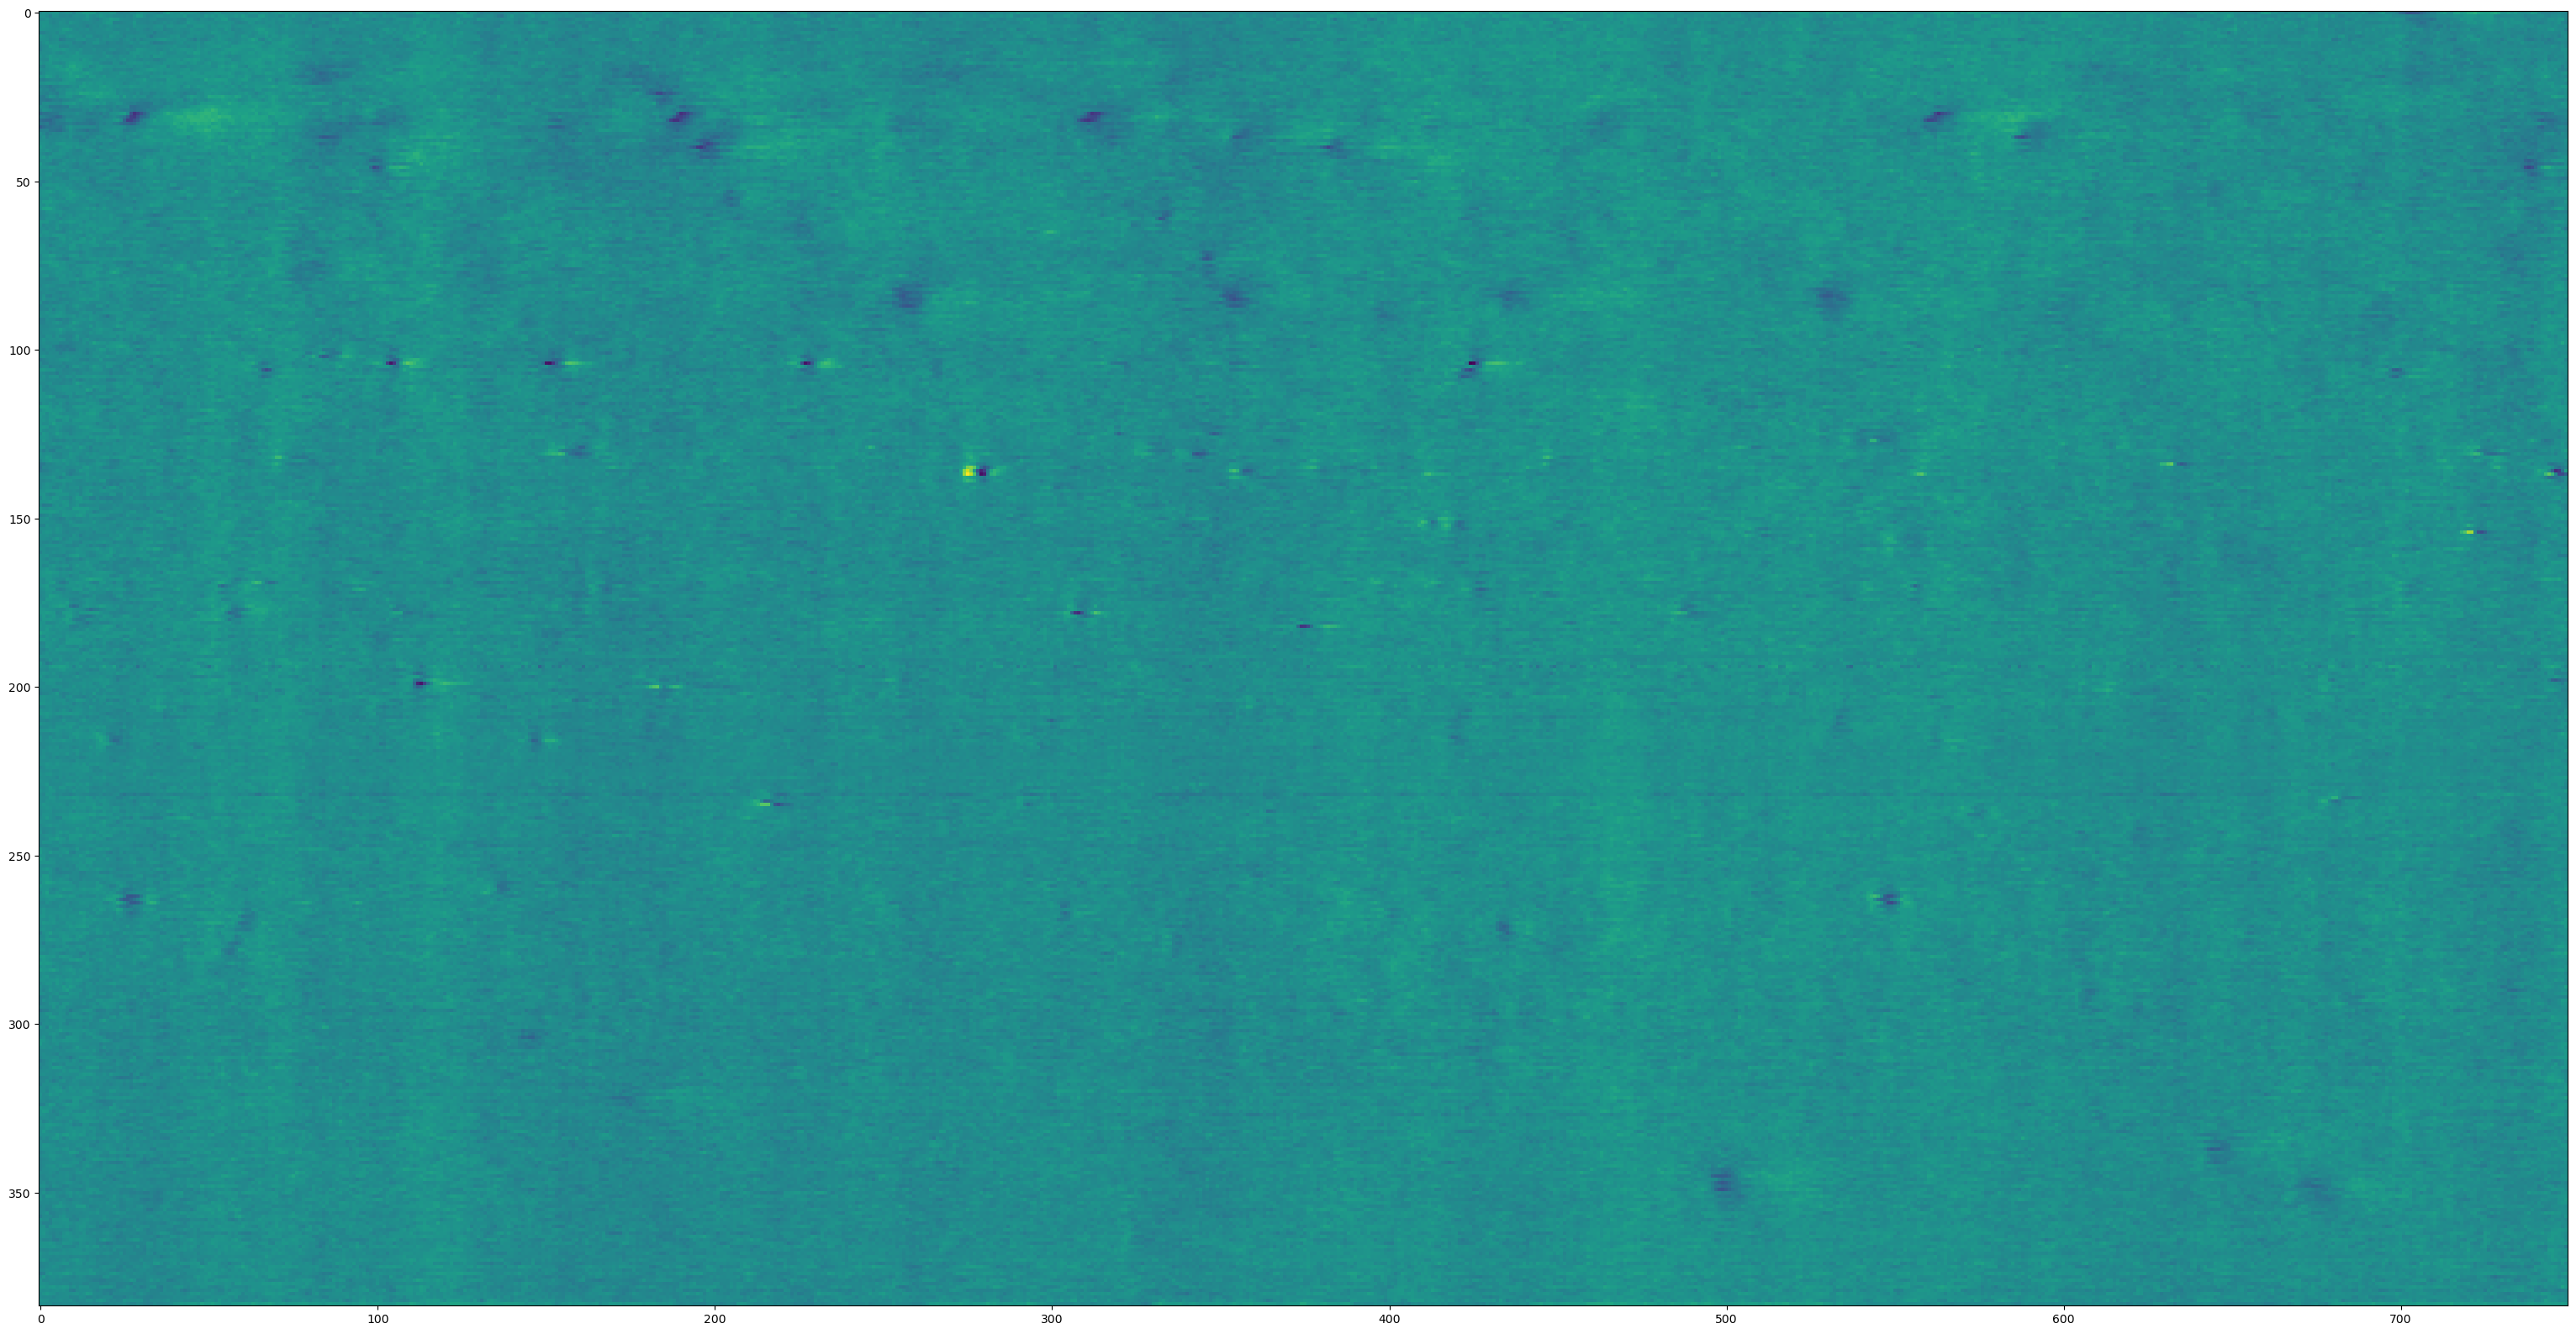

In [69]:
### plot section of raw data

from open_ephys.analysis import Session
OE_raw_path = r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\EJT268\010523\2023-05-01_13-55-12\Record Node 113"

session = Session(OE_raw_path)

data = session.recordings[0].continuous[1].get_samples(start_sample_index=int(8074.9*2500), end_sample_index=int(8075.2*2500))

fig,ax = plt.subplots(1, 1,figsize=(40, 20))

ax.imshow(data[0::].T)

print(data.shape)

In [62]:
## set paths!

mouse_implant_recording = '148_2_2'


OE_processor_path = r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\EJT178\300322\2022-03-30_13-48-39\Record Node 103\experiment1\recording1\continuous"
OE_raw_path = r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\EJT178\300322\2022-03-30_13-48-39\\"

hist_path = r"Z:\projects\sequence_squad\data\histology\Neuropixel_tracks\EJT178_neuropixel\brainreg\manual_segmentation\standard_space\tracks\\"  
hist_file = 'implant1'


##### check date at bottom lines up:

PATH = r"Z:\projects\sequence_squad\organised_data\animals"

for file_ in os.listdir(PATH):
    if 'EJT' in file_.split('_')[0]:
        mouse_number = int(re.findall(r'\d+', file_.split('_')[0])[0])
        implant_number = int(re.findall(r'\d+', file_.split('_')[-1])[0])
        if mouse_implant_recording.split('_')[0] == str(mouse_number):
            if mouse_implant_recording.split('_')[1] == str(implant_number):
                mouse_name = file_.split('_')[0]
                implant_num = implant_number
                PATH = os.path.join(PATH,file_)
                break
for file_ in os.listdir(PATH):
    if 'recording' in file_.split('_')[0]:
        if mouse_implant_recording.split('_')[-1] == str(re.findall(r'\d+', file_.split('_')[0])[0]):
            date_file = file_
            org_data_path = os.path.join(PATH,date_file)
            break
            
print('---------------------------------------------------')
print('DATES should line up:')
print(org_data_path)
print(OE_raw_path)
print(OE_processor_path)
print('---------------------------------------------------')

(750, 385)

In [31]:
data.T

array([[  4.48499984,  -7.21499974, -14.23499948, ..., -35.29499871,
        -35.29499871, -23.59499913],
       [ -7.01999974,  14.03999949,   9.35999966, ..., -44.45999837,
        -72.53999734, -63.17999768],
       [ 13.06499952,  22.42499918,  13.06499952, ..., -31.39499885,
        -38.60999858, -31.39499885],
       ...,
       [ -5.84999979,   3.50999987, -22.22999918, ...,  -5.84999979,
         -5.84999979, -10.52999961],
       [  3.50999987,  -8.1899997 , -19.88999927, ..., -12.86999953,
        -15.20999944, -22.22999918],
       [  1.        ,   1.        ,   1.        , ...,   1.        ,
          1.        ,   1.        ]])

In [138]:
from open_ephys.analysis import Session
OE_raw_path = r"Z:\projects\sequence_squad\data\raw_neuropixel\OE_DATA\EJT255\140423\2023-04-14_11-38-52\Record Node 105"

session = Session(OE_raw_path)

recording = session.recordnodes[0]

data = recording.continuous[0].get_samples(start_sample_index=0, end_sample_index=10000)

AttributeError: 'Session' object has no attribute 'recordnodes'

In [75]:
list(session.recordnodes[0])

TypeError: 'RecordNode' object is not iterable

In [18]:
int_numbers = [float(n) for n in processor]

ValueError: could not convert string to float: 'N'

In [ ]:
ephys_path = os.path.join(os.path.join(dat_path_,recording_),os.listdir(os.path.join(dat_path_,recording_))[0]) + '\\'
analog_path = ephys_path+ os.listdir(ephys_path)[0] + '\\'

    
    
    

In [3]:
#sample rate:
Fs = 2500


hist_path = r"Z:\projects\sequence_squad\organised_data\histology\Neuropixel_tracks\\"

for animal in range(len(mouse_implant_recording)):

    Mouse = mouse_implant_recording[animal].split('_')[0]
    
    if Mouse == '238':
        org_dat_PATH = r"Z:\TEMP_DATA_STORE_during_ceph_migration\emmett\organised_data\\"
    else:
        org_dat_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"

    ## set dat_path:
    for file_ in os.listdir(org_dat_PATH):
        if mouse_implant_recording[animal].split('_')[0] in file_:
            if mouse_implant_recording[animal].split('_')[1] == file_[-1]:
                org_dat_path = os.path.join(org_dat_PATH,file_)
    for recording_file in os.listdir(os.path.join(org_dat_PATH,org_dat_path)):
        if recording_file.split('_')[0][-1] == mouse_implant_recording[animal].split('_')[-1]:
            org_dat_path = os.path.join(org_dat_path,recording_file)
            
    # pull out recording date 
    head, tail = os.path.split(org_dat_path)
    recording_date = tail[-10::]
    
    compressed_date = recording_date.split('-')[0] + recording_date.split('-')[1] + recording_date.split('-')[-1][-2::]
    
    dat_path_ = os.path.join(dat_PATH,'raw_neuropixel\OE_DATA\\')
    for recording_file in os.listdir(dat_path_):
        if Mouse in recording_file:
            if ('implant_' +mouse_implant_recording[animal].split('_')[-1]) in recording_file:
                print(recording_file)
                dat_path_ = os.path.join(dat_path_,recording_file + '\\')

    recordings = os.listdir(dat_path_)
    recording_number = mouse_implant_recording[animal].split('_')[-1]
    for recording_ in recordings:
        if compressed_date == recording_:
            print('found raw data date')
            recording_ = recording_ 
        if recording_number in recording_:
            print('found raw data recording file')
            recording_ = recording_ 
            
    ephys_path = os.path.join(os.path.join(dat_path_,recording_),os.listdir(os.path.join(dat_path_,recording_))[0]) + '\\'
    analog_path = ephys_path+ os.listdir(ephys_path)[0] + '\\'

            
    print(ephys_path)  
            
            
            
            

NameError: name 'mouse_implant_recording' is not defined

In [20]:
# recording_date.split('-')[0] 

recording_date.split('_')

# recording_date.split('-')[-1][-2::]

['29', '03', '2022']

In [19]:
recording_date

'29_03_2022'

NameError: name 'analog_path' is not defined

In [6]:
analog_path

NameError: name 'analog_path' is not defined

In [ ]:
# np track
# analog path
# ephys path 

148_2_2
EJT148_implant_2
found raw data recording file


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Z:\\projects\\sequence_squad\\data\\\\raw_neuropixel\\OE_DATA\\EJT148_implant_2\\not_these ones\\EJT48_2020-10-19_10-59-09\\experiment1\\recording2\\continuous/continuous'

In [25]:
 os.listdir(dat_path_)

['EJT48_2020-10-19_14-14-28', 'not_these ones']

In [26]:
dat_path_

'Z:\\projects\\sequence_squad\\data\\\\raw_neuropixel\\OE_DATA\\EJT148_implant_2\\'

In [10]:
recording_file

'EJT49'

In [11]:
os.listdir(dat_path_)

['.DS_Store',
 'EJT136',
 'EJT136_implant2',
 'EJT149_implant2',
 'EJT162',
 'EJT178',
 'EJT178_implant2',
 'EJT186',
 'EJT238',
 'EJT48_implant_1',
 'EJT48_implant_2',
 'EJT49']

In [ ]:
recording = align_open_ephys_processors(main_processor_tuple,aux_processor_tuples,OE_raw_path)
recording.compute_global_timestamps()